In [1]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.utils import to_categorical 
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report
from os import walk, listdir
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers
import random
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

import csv 
from PIL import Image

In [2]:
# accessing to data 

path_training = 'BelgiumTSC_Training\Training'
path_testing = 'BelgiumTSC_Testing\Testing'

nbr_class = 62 # len(next(walk(path_training))[1])  counting the number of classes 
print('number of classes : ', nbr_class)

#-----------------------------------------------------------------------------

# resol is the format for the images that we want for convenience

resol = (30,30)

#-----------------------------------------------------------------------------

# retrieving the number of images to be treated in the training folder

DIR = path_training
counter = 0
for root, dirs, files in walk(DIR) :
    for file in files:    
        if file.endswith('.ppm') or file.endswith('.jpeg'):
            counter += 1

print("number of images in the training folder : ", counter)

#-----------------------------------------------------------------------------

# Creating an image.DirectoryIterator to work over the images of the training folder 

# We rescale the images when we iterate over it and we will do a zoom and a flip  

train_datagen = ImageDataGenerator( rescale =1./255, zoom_range = 0.2, horizontal_flip = True)
training_set = train_datagen.flow_from_directory(path_training,target_size = resol,
batch_size = counter,class_mode = 'binary', color_mode='rgb')

#-----------------------------------------------------------------------------

# retrieving the number of images to be treated in the testing folder

DIR = path_testing
counter = 0
for root, dirs, files in walk(DIR) :
    for file in files:    
        if file.endswith('.ppm') or file.endswith('.jpeg'):
            counter += 1

print("number of images in the testing folder : ", counter)


#-----------------------------------------------------------------------------

# Creating an image.DirectoryIterator to work over the images of the testing folder 

# We rescale the images when we iterate over it 

test_datagen = ImageDataGenerator( rescale =1./255)
test_set = test_datagen.flow_from_directory(path_testing,target_size = resol,
batch_size = counter,class_mode = 'binary', color_mode='rgb')

number of classes :  62
number of images in the training folder :  4575
Found 4575 images belonging to 62 classes.
number of images in the testing folder :  2520
Found 2520 images belonging to 62 classes.


In [3]:
# Storing all the information in arrays for convenience 

X_train , y_train = training_set.next()
X_test , y_test = test_set.next()

print("Shape of X_train : ", X_train.shape)
print("Shape of y_train : ", y_train.shape)
print("Shape of X_test : ", X_test.shape)
print("Shape of y_test : ", y_test.shape)

# talk : is it still necessary ?

#data augmentation
'''aug = ImageDataGenerator(
	rotation_range=10,
	zoom_range=0.15,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.15,
	horizontal_flip=False,
	vertical_flip=False,
	fill_mode="nearest")
aug.fit(X_train)'''

Shape of X_train :  (4575, 30, 30, 3)
Shape of y_train :  (4575,)
Shape of X_test :  (2520, 30, 30, 3)
Shape of y_test :  (2520,)


'aug = ImageDataGenerator(\n\trotation_range=10,\n\tzoom_range=0.15,\n\twidth_shift_range=0.1,\n\theight_shift_range=0.1,\n\tshear_range=0.15,\n\thorizontal_flip=False,\n\tvertical_flip=False,\n\tfill_mode="nearest")\naug.fit(X_train)'

Number of each sign in the train set : 

[ 15 110  13  15  15  11  18 157  27  18  21   7  18  90  43   9   9  79
  81 231  42  43 375  15  48  42   6  18 125  33  37  63 316  12  46  60
  18  98 285 196 242 148  35  30  48  74  44 147  11  12  15  27  27 199
 118  12  95  78  15  42   9 282]

Total of signs :  4575

Number of each sign in the test set : 

[  6  27   7   6  12   3   6  90  12   0  28   0   3  39  15   0  12 183
 122 163   3  45  61  15  13   3   0   9  51  28  37  86 422   0   9 154
   0  31 213  99  48  11   9   6   3  84   6  31   0   3   0   3   0  24
  48  15  33  41   9  17  11 105]

Total of signs :  2520


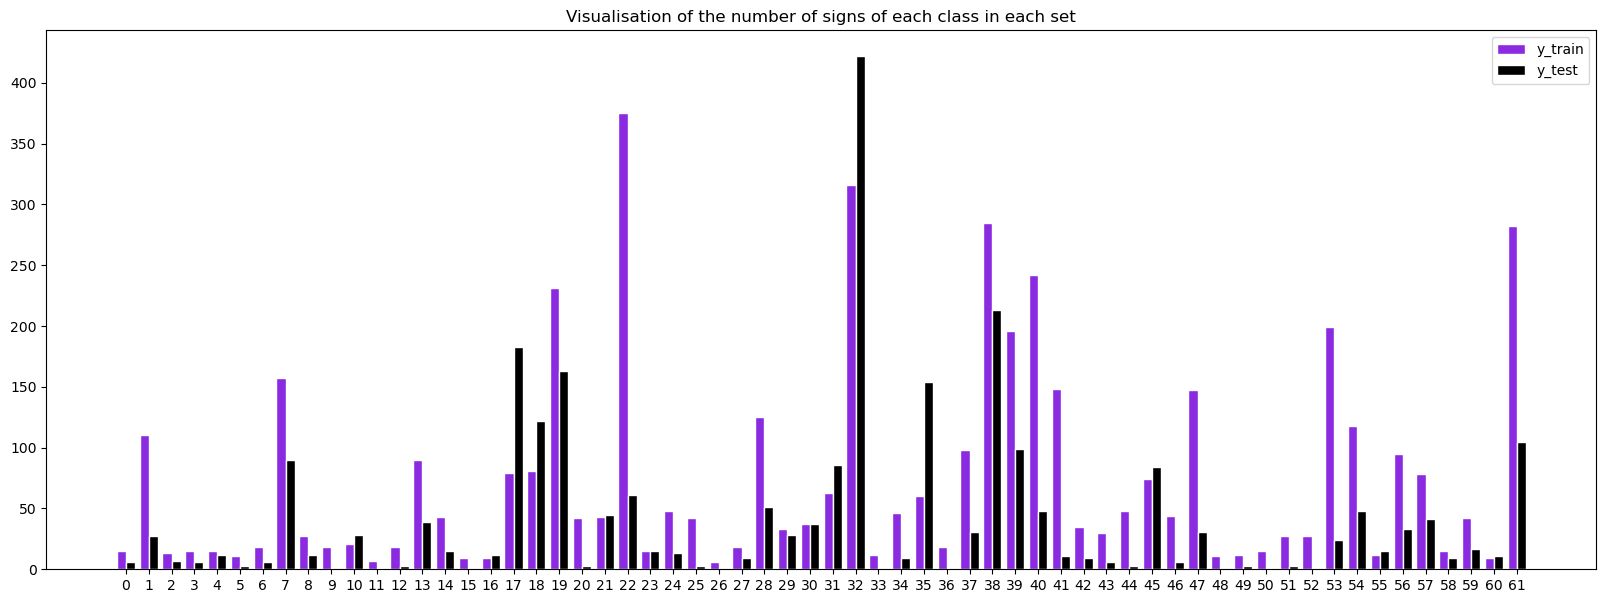

In [4]:
# This cell is about visualisation of the dataset 

a = np.zeros(nbr_class, dtype=int)
b = np.zeros(nbr_class, dtype=int)

for i in range(nbr_class) :
    a[i] = int((y_train == i).sum())  # Number of images of class i in the Training set
    b[i] = int((y_test == i).sum())   # Number of images of class i in the Test set 

print("Number of each sign in the train set : ")
print()
print(a)
print()
print("Total of signs : ", a.sum())
print()

print("Number of each sign in the test set : ")
print()
print(b)
print()
print("Total of signs : ", b.sum())

# We plot an histo showing how many signs of each class we have in each set 

fig, ax = plt.subplots(figsize = (20, 7))
bins = [x + 0.5 for x in range(-1, nbr_class)]
ax.hist([y_train, y_test], range = (0, nbr_class-1), bins=bins, edgecolor = 'white', color = ['blueviolet','black'], label = ['y_train', 'y_test'])
plt.title("Visualisation of the number of signs of each class in each set")
plt.xticks(np.arange(nbr_class))
plt.legend()
plt.show()

In [5]:
# We put our results to categorical 

# talk Some explanations needed ...

y_train = to_categorical(y_train, nbr_class)
y_test = to_categorical(y_test, nbr_class)

print("Shape of y_train with second method : ", y_train.shape)
print("Shape of y_test with second method : ", y_test.shape)

Shape of y_train with second method :  (4575, 62)
Shape of y_test with second method :  (2520, 62)


In [6]:
# We construct our model using CNN architecture (AlexNet, LeNet)

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]) )
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(nbr_class, activation='softmax'))

#Compilation of the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 11, 11, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 11, 11, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 64)          18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 64)          36928     
                                                        

In [7]:
# We train here the model with the second method of augmentation 

eps = 3 # The number of time we want the model to train on the entire training_set

mycallbacks = [EarlyStopping(monitor='val_loss', patience=5)]
anc = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=eps, callbacks=mycallbacks)
#added aug.flow to (X_train, y_train) to do data augmentation

# talk : aug.flow ? 

Epoch 1/3
143/143 [==============================] - 28s 152ms/step - loss: 3.0856 - accuracy: 0.2706 - val_loss: 1.6974 - val_accuracy: 0.5734
Epoch 2/3
143/143 [==============================] - 17s 121ms/step - loss: 1.4973 - accuracy: 0.6173 - val_loss: 0.8806 - val_accuracy: 0.7933
Epoch 3/3
143/143 [==============================] - 18s 124ms/step - loss: 0.9798 - accuracy: 0.7272 - val_loss: 0.6174 - val_accuracy: 0.8329


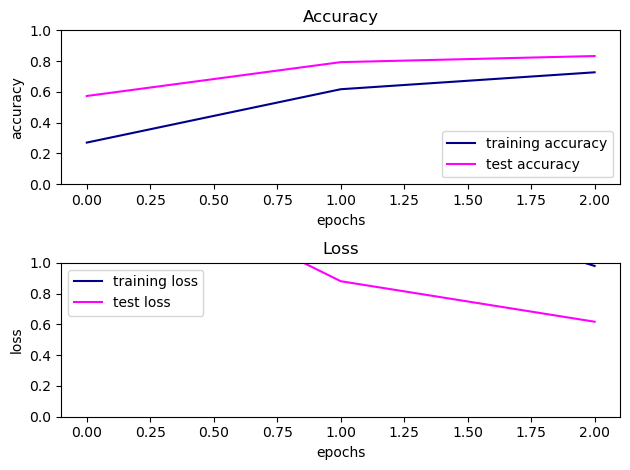

In [8]:
# Plot of performances 

plt.figure()

plt.subplot(2, 1, 1)
plt.plot(anc.history['accuracy'], label='training accuracy', color = 'darkblue')
plt.plot(anc.history['val_accuracy'], label='test accuracy', color = 'magenta')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.ylim(0, 1)

plt.subplot(2, 1, 2)
plt.plot(anc.history['loss'], label='training loss', color = 'darkblue')
plt.plot(anc.history['val_loss'], label='test loss', color = 'magenta')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

In [9]:
# We store all of the images from the kaggle folder in an array 
# recall that target has been defined above 

images = [] 
names = []

# get the path/directory
folder_dir = 'eval_kaggle1'

for image in listdir(folder_dir):
    # check if the image ends with ppm
    if (image.endswith(".ppm")):
        img = Image.open(folder_dir + '/' + image)
        img = img.resize(resol) # (30,30) as an example 
        img = np.asarray(img)
        images.append(img) 
        names.append(image.replace('.ppm',''))

images = np.array(images)

print(images.shape)
print(type(images))

(202, 30, 30, 3)
<class 'numpy.ndarray'>


In [10]:
# We print there the predictions for the dataset of kaggle 

print("[INFO] evaluating network...")

predictions = model.predict(images).argmax(axis=1)
print(predictions)
print(len(predictions))

[INFO] evaluating network...
7/7 [==============================] - 1s 17ms/step
[14 38 48 61 19 20 21  7 21  7 45 40 37 22  7 61 44 32 40 59 38 14 38 61
 21 32 59 28  7 61 28 19 21 25 28 37 44 14  7 61 28 56 28  1 61  1 28 13
  1 56 56 31 22 61  8 39 31  7 32 53 28 19 17 37 38 38 32 35 56 61 17 28
 35 28  7 56 47 18 28 37 17 32  1 28 22 28 32 54 61 37 34 14 21 18  7 37
 51 13 38 57 28 13 44 38 30 22 59 18 61 59 19  7 53 32 38 56 13 14 13  1
 25 13 45 18 32 25 17 53 14 61 53 32  7 22 32 54 51 34 37  8 29  7 37 38
 35 25 56 38  7  7 32 39 39 22 25 38 29 25 37 37 13 56  7 35 38 13 31 54
 13  1 38 54 32 53 38  7 14 28 14 32  1 18 38  8 40 13 61 45 57 18 13 38
 28 13 38 28 14 30 31 56 61 38]
202


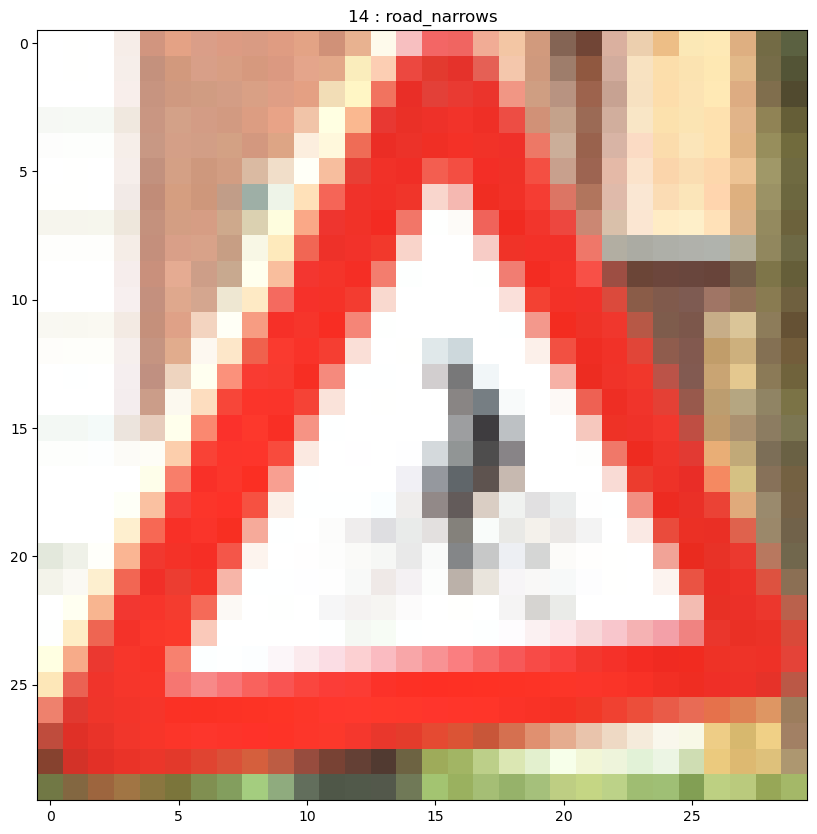

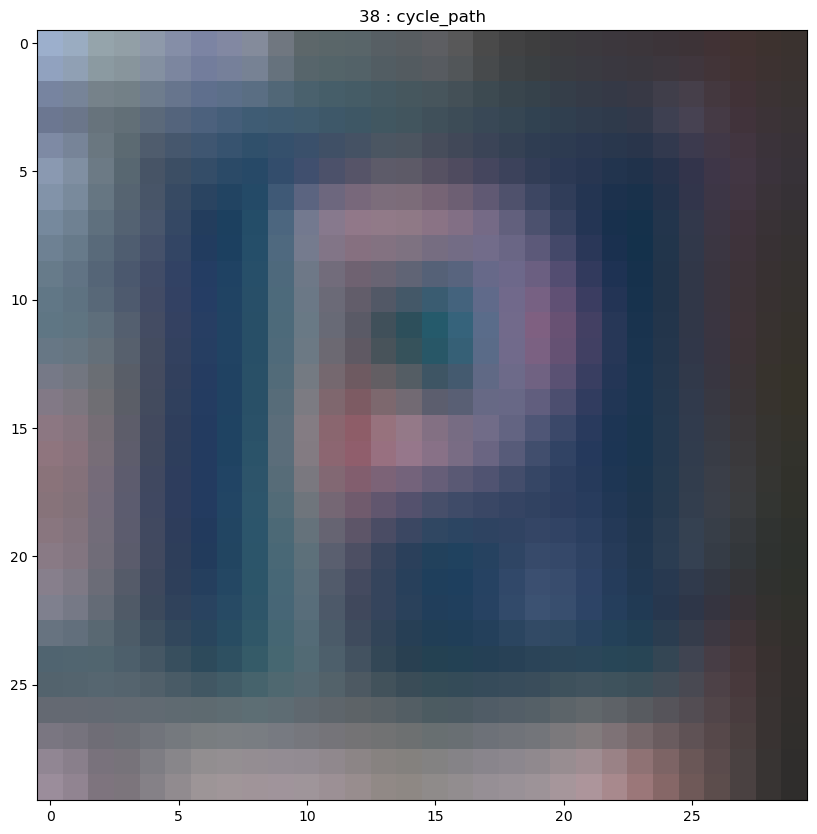

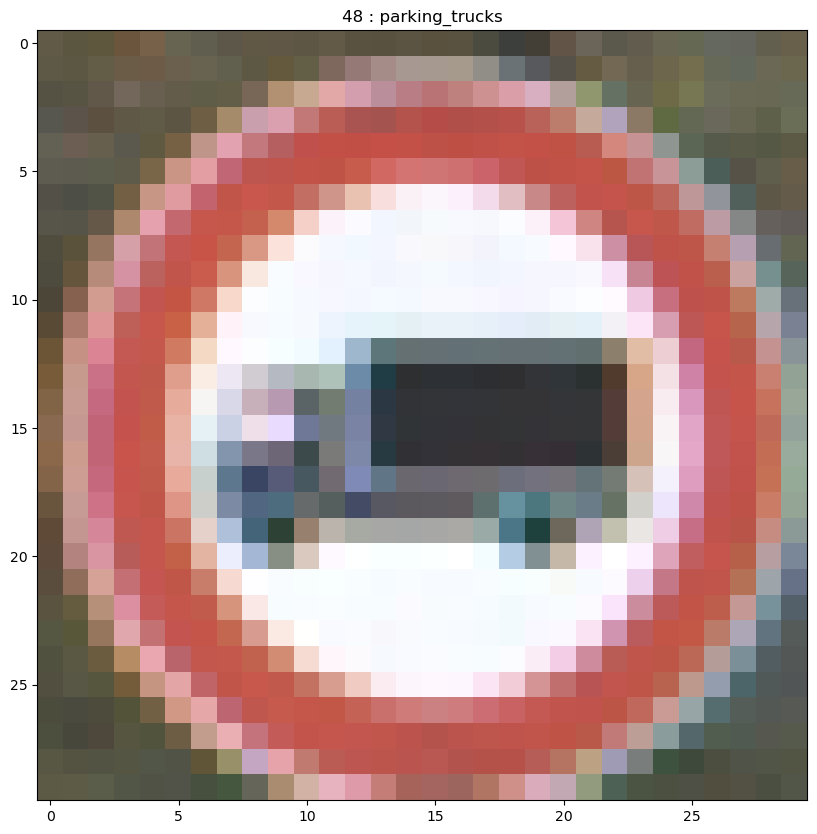

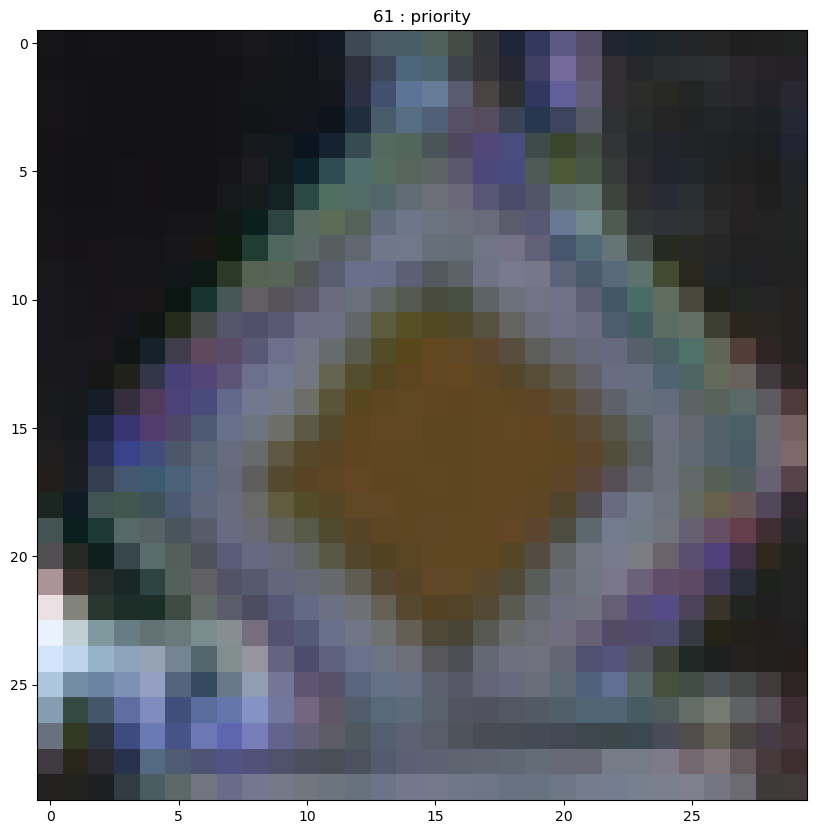

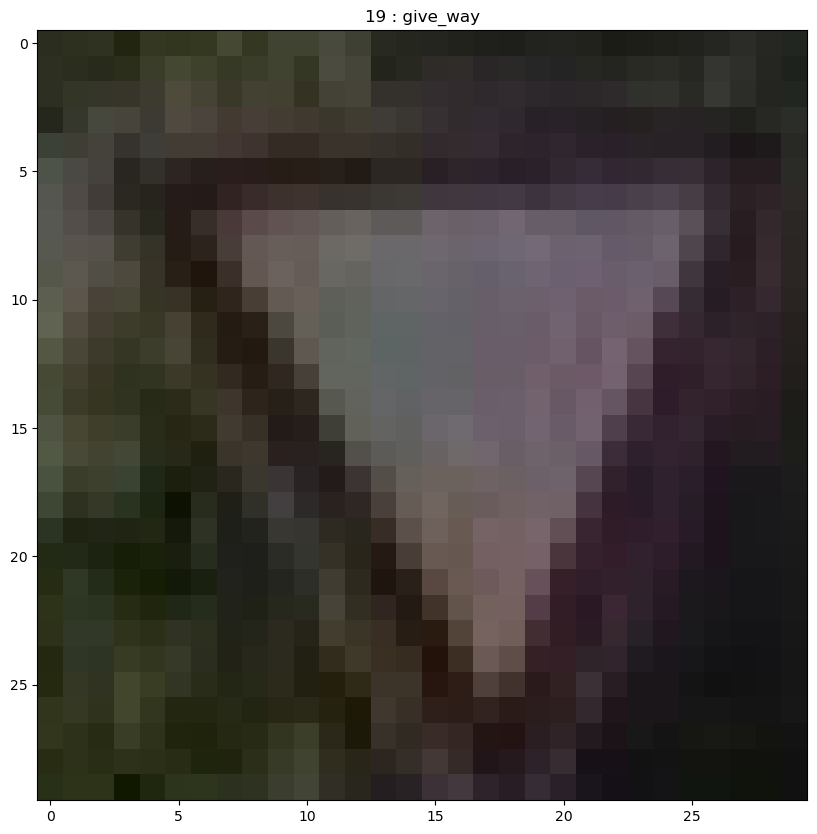

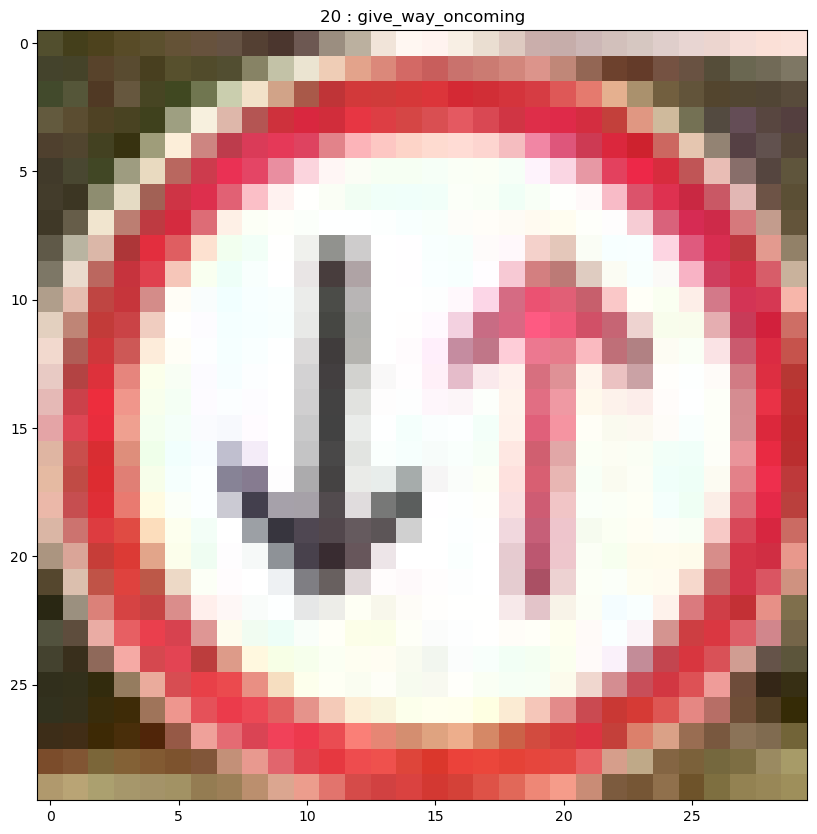

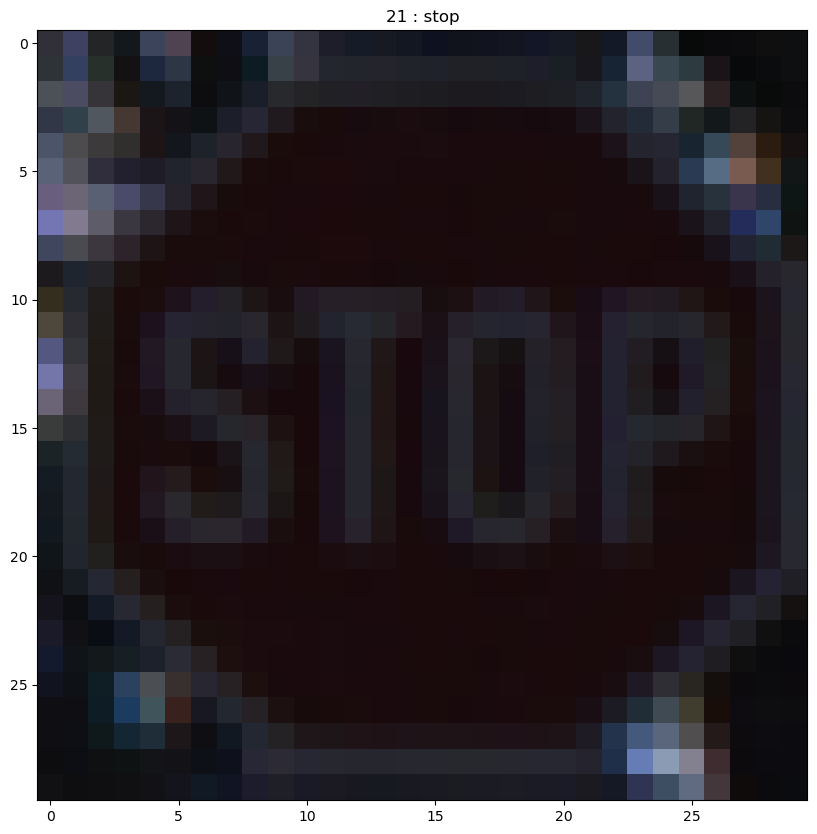

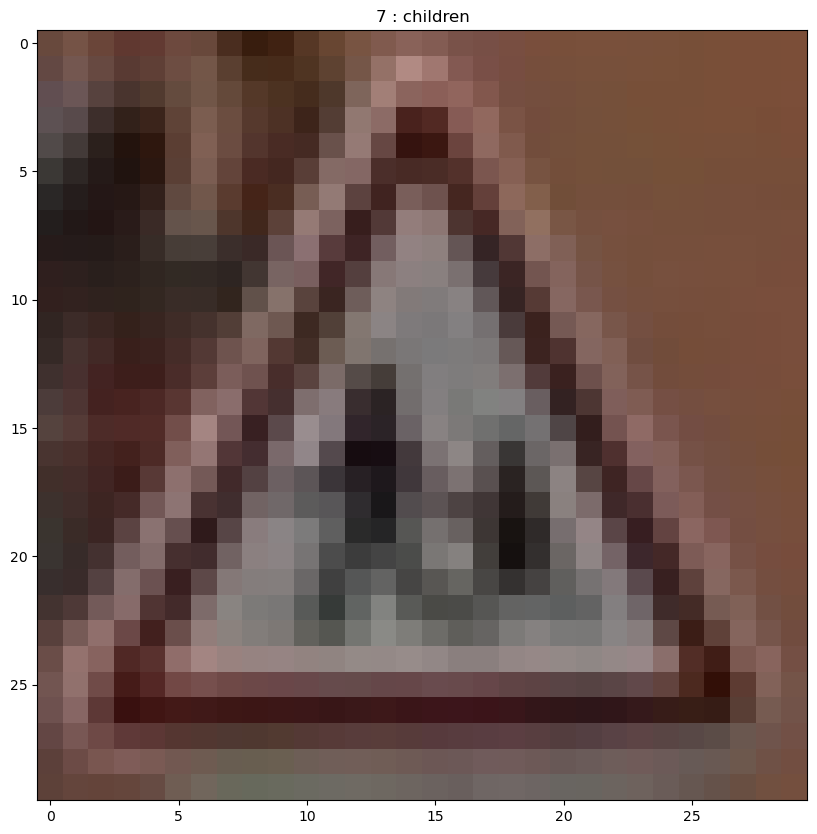

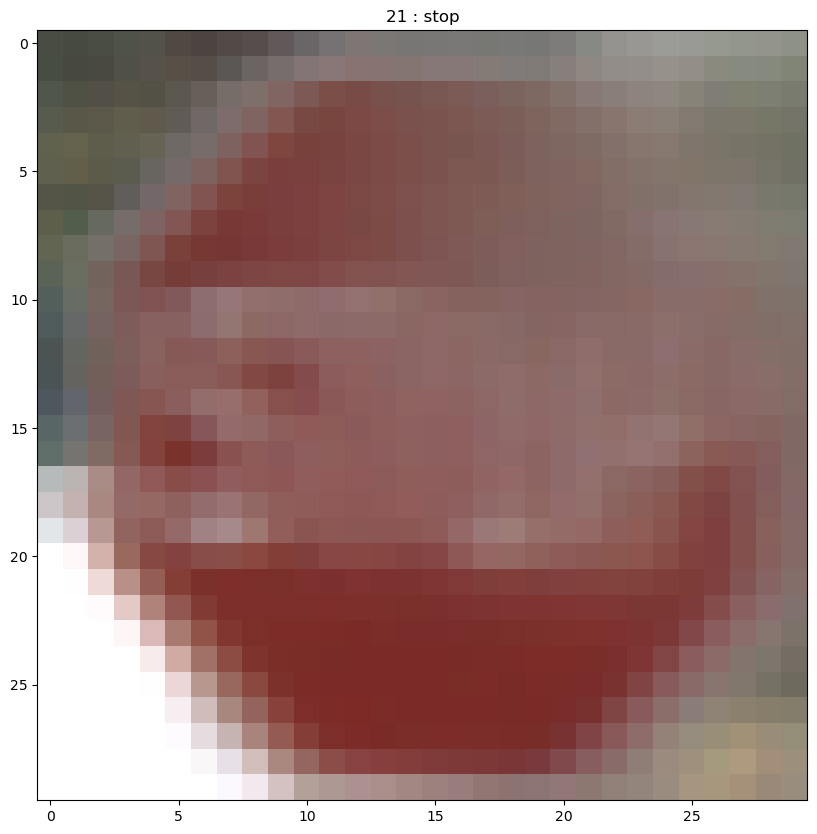

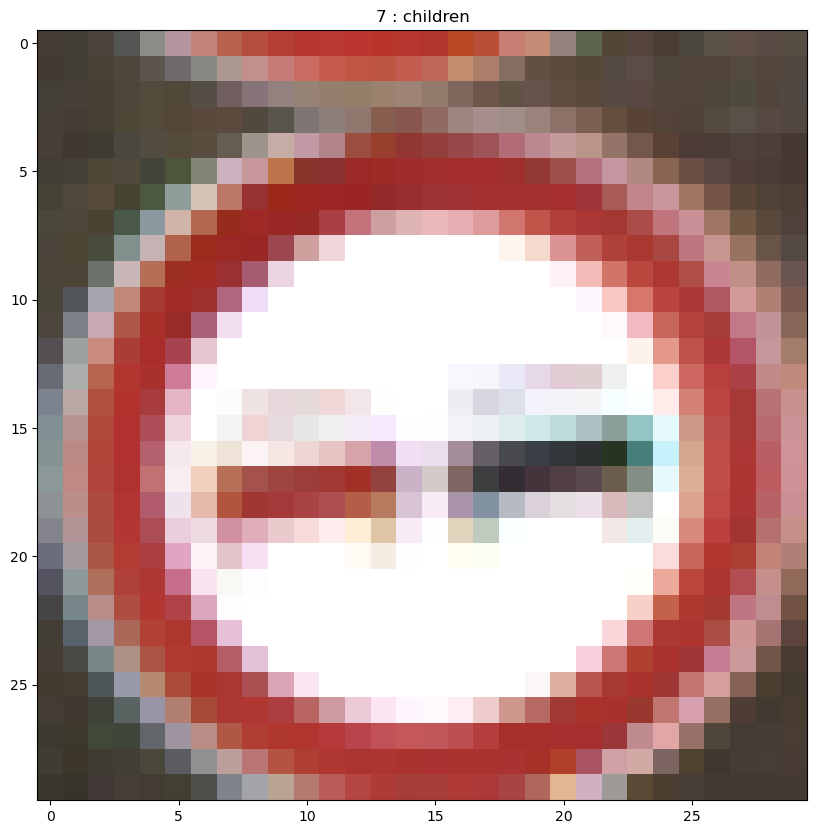

In [11]:
# We will store the data in dict.csv in a dict 

data = {}

with open('dict.csv', 'r') as f:
    d_reader = csv.DictReader(f, fieldnames=["num", "sign"])

    #get fieldnames from DictReader object and store in list
    for row in d_reader:
        data[row['num']] = row['sign']

# We then print the image with num and the sign predicted as a title 
 
for i in range(10): 
    plt.figure(figsize = (10,10))
    plt.imshow(images[i])
    sign = data[str(predictions[i])]
    plt.title(str(predictions[i]) + " : " + str(sign))

In [12]:
# Here is the code to write the results in a CSV for kaggle 

with open('final.csv', 'w', newline='') as csvfile:
    fieldnames = ['Id', 'Category']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for i in range(len(predictions)): 
        writer.writerow({'Id' : names[i], 'Category' : predictions[i]})

In [13]:
# Here is a code to save all ppm in jpeg in a directory called names (must be created)

# get the path/directory
folder_dir = "eval_kaggle1"

for image in listdir(folder_dir):
    # check if the image ends with ppm
    if (image.endswith(".ppm")):
        img = Image.open(folder_dir + '/' + image)
        img.save("names" + '/' + image.replace('.ppm','.jpg'), format = 'JPEG') 